In [1]:
import sys
import os
from pathlib import Path
from typing import Tuple

import torch
import torchaudio
from torch import Tensor
from torch.utils.data import Dataset
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural networks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

import math
import random
import numpy as np
import librosa
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
ROOT_DIR='/content/drive/MyDrive/College/Research/Linh_2023_Research'
sys.path.append(ROOT_DIR)

Mounted at /content/drive


train cnn on vox



Text(0.5, 0, 'Number of Speakers')

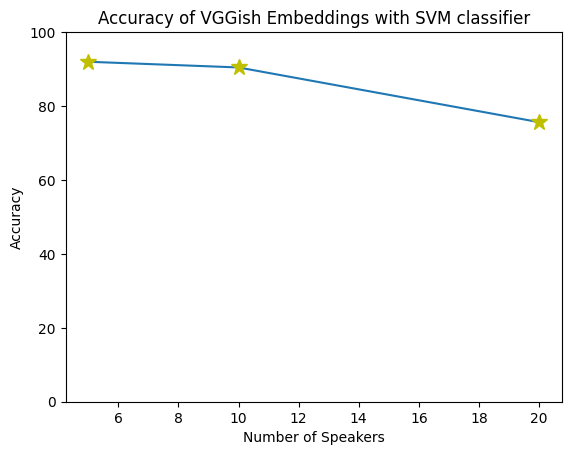

In [ ]:
five = [0.94447660,0.95706898,0.95934319,0.94880545,0.32394856,0.96585649,0.95991272,0.95634270,0.96104479,0.90679061,0.92205840,0.95092440,0.92154872,0.95683944,0.95309526,0.94056165,0.94644040,0.90275872,0.96498823,0.93177980,0.93074518,0.94423437,0.96645796,0.92889559,0.95119870]
ten = [0.90047634,0.85916662,0.88760287,0.91713089,0.88994265,0.91689712,0.92651540,0.91207546,0.91933054,0.90255326,0.93229455,0.88642770,0.91912723,0.92506468,0.94099718,0.90749002,0.90065914,0.91762137,0.87230527,0.87131679,0.89855266,0.87554008,0.92138267,0.89781547,0.91194147]
twenty = [0.54047787,0.83028978,0.86905277,0.84565496,0.50137204,0.84981763,0.85792303]
import statistics as s
avg = [s.mean(five) * 100, s.mean(ten) * 100, s.mean(twenty) * 100]
fig, axs = plt.subplots()
plt.plot([5,10,20], avg)
plt.plot([5,10,20], avg, 'yo', markersize=12)
plt.ylim(0,100)
axs.set_title('Accuracy of VGGish Embeddings with SVM classifier')
# axs.legend(['Loss', 'Accuracy'])
axs.set_ylabel('Accuracy')
axs.set_xlabel('Number of Speakers')

Helper functions

In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  # figure.suptitle(title)
  # plt.show(block=False)
  plt.show()

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title('Spectrogram (db)' if not title else title)
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  # plt.show(block=False)
  # plt.savefig(title, bbox_inches='tight')
  plt.show()

Data processing

In [45]:
# Spectrogram parameters
n_fft = 512
# win_length = 320        # 16000 samples * 20ms * 0.001 s/ms
image_width = 64
frame_length = 512
step_length = 0.008

def collate_fn(data):
    """
    data: is a list of tuples with (example, label, length)
            where 'example' is a tensor of arbitrary shape
            and label/length are scalars
    """
    _, labels, lengths = zip(*data)     # ([batch_size, num_channels, partsCount, 32, 128], [label])
    max_len = max(lengths)
    n_ftrs = data[0][0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs))
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)

    for i in range(len(data)):
        j, k = data[i][0].size(0), data[i][0].size(1)
        features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k))])

    return features.float(), labels.long(), lengths.long()

class SpeakerData(Dataset):
    """Create a Dataset for Speech Commands.

    Args:
        root (str): Path to the directory where the dataset is found or downloaded.
    """
    def __init__(self, root: str, num_classes: int) -> None:
        super().__init__()
        self.root_path = root
        self.samples = self.make_samples(num_classes)
        self.labels, self.label2idx = self.load_labels(self.samples)
        # self.targets = [s[1] for s in self.samples]

    def __len__(self) -> int:
        return len(self.samples)
    
    def make_samples(self, num_classes: int) -> list[Tuple[str, int]]:
        """Create samples for imported dataset.

        Returns:
            List[Tuple[str, int]]: samples of a form (path_to_sample, class)
        """
        # TODO: exclude id10384
        classes = random.sample(os.listdir(self.root_path), num_classes)
        paths = []
        # for p in Path(self.root_path).glob("*/*/*.flac"):
        for p in Path(self.root_path).glob("*/*.wav"):
            label = str(p).split("/")[-2]
            if label in classes:
                paths.append((str(p), label))
        paths.sort()
        return paths

    def _load_item(self, filepath: str, path: str) -> Tuple[Tensor, int, int]:
        relpath = os.path.relpath(filepath, path)
        label = relpath.split("/")[0]
        # Load audio
        waveform, sample_rate = torchaudio.load(filepath)
        return waveform, sample_rate, label

    def load_labels(self, samples: list):
        labels = []
        label2idx = {}
        cur = -1
        count = 0
        for n in samples:
            if cur != n[1]:
              labels.append(n[1])
              label2idx[n[1]] = count
              count += 1
              cur = n[1]
        return labels, label2idx
    
    def _load_labels(self, path: str):
        labels = []
        label2idx = {}
        count = 0
        for dir in os.listdir(path):
            labels.append(dir)
            label2idx[dir] = count
            count += 1
        return labels, label2idx
    
    def __getitem__(self, n: int) -> Tuple[Tensor, int]:
        """Load the n-th sample from the dataset.

        Args:
            n (int): The index of the sample to be loaded

        Returns:
            X (tensor): features tensor
            Y (int): label id
        """
        filepath = self.samples[n][0]
        waveform, sample_rate, label = self._load_item(filepath, self.root_path)

        # Transformations
        frame_step = int(sample_rate * step_length) # 328
        spec = torch.stft(waveform,           # spec.shape = (1, freq_bin, audio_len)
                          n_fft=frame_length, 
                          hop_length=frame_step, 
                          return_complex=True)
        
        transform = torchaudio.transforms.Spectrogram(
            n_fft=n_fft,
            hop_length=image_width
        )
        resize = torchvision.transforms.Resize((32, 128))
        # spec_db = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)
        # image_transform = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # spec = transform(waveform)
        # print('spec', spec.shape)
        X = torch.transpose(spec, 1, 2) # X.shape = (1, audio_len, freq_bin)
        X = torch.real(X)
        X = torch.abs(X)
        
        # Get multiple parts of size (image_width, n_fft)
        audio_len= spec.shape[2]
        if audio_len > image_width:
            partsCount = audio_len // image_width
            parts = torch.zeros((partsCount, image_width, int(n_fft/2+1)))
            # print('parts', parts.shape)
            for i in range(partsCount):
                p = i * image_width
                # print(X[:,p:p+image_width,:].shape, p+image_width)
                parts[i] = X[:,p:p+image_width,:]
            # print('parts', parts.shape)
        else:
            parts = X
        
        # plot_spectrogram(spec.view(spec.shape[1], spec.shape[2]), title='origin')
        # plot1 = torch.zeros((partsCount * image_width, spec.shape[1]))
        # for i in range(partsCount):
        #     p = i * image_width
        #     plot1[p:p+image_width,:] = parts[i]
        #     # print(plot1[:,i:i+image_width].shape)
        # plot1 = torch.transpose(plot1, 0, 1)
        # print(spec.shape, plot1.shape)
        # plot_spectrogram(plot1, title='reshaped')

        parts = resize(parts)
        Y = self.label2idx[label]

        return parts, Y

In [4]:
DATA_PATH = ROOT_DIR + "/test_data/vox"
# DATA_PATH = ROOT_DIR + "/test_data/librispeech/dev-clean"
# librispeech: shortest, longest: 46, 1021
data = SpeakerData(DATA_PATH, 1)
print(len(data))
print(len(data.labels), data.labels)
print(data.label2idx)
# feature, label = data[0]
item, label = data.__getitem__(random.randint(0,len(data)))
print(item.shape)
# max_len, min_len = 0, float('inf')
# for i in data:
#   feature, label = i
#   cur = feature.shape[2]
#   max_len = max(max_len, cur)
#   min_len = min(min_len, cur)
# print(max_len, min_len)
# feature = feature[-1,:,:]
# print(feature.shape)
# plot_spectrogram(feature, title=label)
    
# waveform = normalize(feature)
# spec = spectrogrameToImage(waveform)
# spec = spec.convert('RGB')

# plt.figure()
# plt.imshow(feature)

109
1 ['id10494']
{'id10494': 0}
torch.Size([7, 32, 128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [46]:
class SpeakerCNN(nn.Module):
    ''' Models a simple Convolutional Neural Network'''
    def __init__(self, num_class):
      ''' initialize the network '''
      super(SpeakerCNN, self).__init__()
      # 1 input image channel, 8 output channels, 
      # 3x3 square convolution kernel
      self.conv1 = nn.Conv2d(1, 8, 3, padding='same')
      self.conv2 = nn.Conv2d(8, 16, 3, padding='same')

      self.conv3 = nn.Conv2d(16, 16, 3, padding='same')
      self.conv4 = nn.Conv2d(16, 32, 3, padding='same')

      self.conv5 = nn.Conv2d(32, 32, 3, padding='same')
      self.conv6 = nn.Conv2d(32, 64, 3, padding='same')

      # Max pooling over a (2, 2) window
      self.pool = nn.MaxPool2d(2, 2)
      # Average pooling over a (3, 3) window
      self.avgpool = nn.AvgPool2d(3, 3)

      self.fc1 = nn.Linear(64 * 10 * 2, 16)# 3x3 from image dimension
      self.fc2 = nn.Linear(16, num_class)

    def forward(self, x):
      ''' the forward propagation algorithm '''
      # print('input', x.shape)
      x = self.pool(F.relu(self.conv2(F.relu(self.conv1(x)))))
      # print('after 1st block', x.shape)
      x = self.pool(F.relu(self.conv4(F.relu(self.conv3(x)))))
      # print('after 2nd block', x.shape)
      x = F.relu(self.conv6(F.relu(self.conv5(x))))
      # print('after 3rd block', x.shape)
      x = self.avgpool(x)
      # print(x.shape)
      x = x.view(-1, 64 * 10 * 2)
      x = self.fc1(x)
      x = torch.sigmoid(self.fc2(x))
      # print(x)
      # print()
      return x

In [57]:
# DATA_PATH = ROOT_DIR + "/test_data/leaderspeech"
DATA_PATH = ROOT_DIR + "/test_data/vox"
# DATA_PATH = ROOT_DIR + "/test_data/librispeech/dev-clean"

# Hyper-parameters
train_test_ratio = 0.8
num_classes = 5   # 395 in vox, 40 in librispeech, 5 in leaderspeech
batch_size = 1
learning_rate = 0.0001
# features_size = 128
# hidden_size = 64
# num_layers = 3

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import data
dataset = SpeakerData(DATA_PATH, num_classes) # shortest, longest: 46, 1021
train_size = int(train_test_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model_acc = []

# Save title for training figure
title = ""
for speaker in dataset.labels:
    title += speaker + "\n"
print(title)

id10179
id10384
id10527
id10554
id10955



Models

In [71]:
# RNN model
# rnn_model = RNN(features_size, hidden_size, num_layers, num_classes, device).to(device)
# print(model)

# CNN model
cnn_model = SpeakerCNN(num_classes)

# ResNet34
# from torchvision.models import resnet34
# # Load ResNet34 CV model
# resnet_model = resnet34(weights=True)
# # Adjusted the last layer output for our binary classification use case
# resnet_model.fc = nn.Linear(512, num_classes)
# # Adjust the first convolution neural network (CNN) layer for our use case
# resnet_model.conv1 = nn.Conv2d(
#   1,
#   64,
#   kernel_size=(7, 7),
#   stride=(2, 2),
#   padding=(3, 3),
#   bias=False
# )

model = cnn_model
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Train

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[1,   200] loss: 1.49536
[2,   200] loss: 1.47525
[3,   200] loss: 1.43335
[4,   200] loss: 1.42533
[5,   200] loss: 1.38034
[6,   200] loss: 1.38813
[7,   200] loss: 1.31674
[8,   200] loss: 1.37023
[9,   200] loss: 1.30394
[10,   200] loss: 1.28656
[11,   200] loss: 1.25106
[12,   200] loss: 1.25867
[13,   200] loss: 1.23472
[14,   200] loss: 1.21068
[15,   200] loss: 1.23966
[16,   200] loss: 1.19913
[17,   200] loss: 1.22125
[18,   200] loss: 1.18313
[19,   200] loss: 1.18257
[20,   200] loss: 1.18360
[21,   200] loss: 1.19239
[22,   200] loss: 1.13926
[23,   200] loss: 1.14288
[24,   200] loss: 1.07040
[25,   200] loss: 1.12846
[26,   200] loss: 1.07697
[27,   200] loss: 1.06700
[28,   200] loss: 1.06019
[29,   200] loss: 1.04771
[30,   200] loss: 1.04535
[31,   200] loss: 1.04669
[32,   200] loss: 1.03811
[33,   200] loss: 1.03092
[34,   200] loss: 1.04142
[35,   200] loss: 1.02950
[36,   200] loss: 1.04549
[37,   200] loss: 1.03396
[38,   200] loss: 1.02156
[39,   200] loss: 1.0

<Figure size 640x480 with 0 Axes>

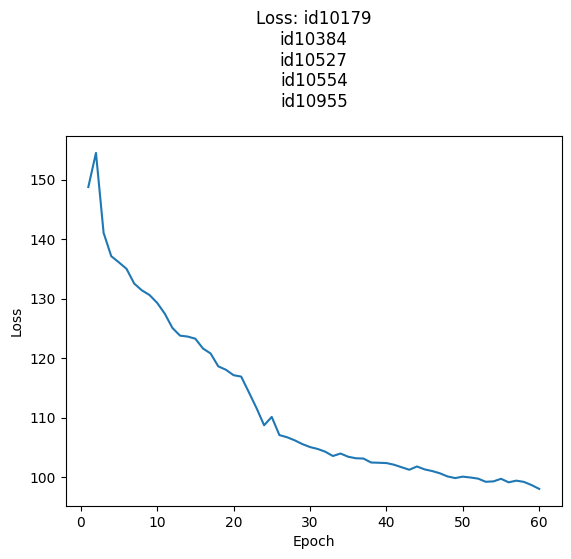

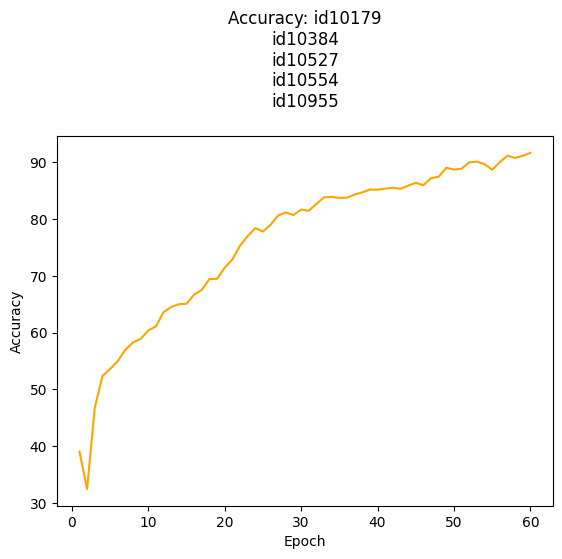

In [72]:
num_epochs = 25
loss_plt = []
acc_plt = []
for epoch in range(num_epochs):
    loss_per_epoch = 0.0
    correct = 0.0
    running_loss = 0.0
    steps = 0
    total_steps = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # if i > 5: break
        # images = images.view(batch_size, images.shape[1], features_size)  # RNN
        images = images.to(device)
        labels = labels.to(device)
        
        for j in range(images.shape[1]):
            single_image = images[:,j:j + 1,:,:]
            # single_image = torch.transpose(single_image, 2, 3)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(single_image)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Print data (CNN)
            loss_per_epoch += loss.item()
            running_loss += loss.item()
        total_steps += images.shape[1]
        steps += images.shape[1]

        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps:.5f}')
            steps = 0
            running_loss = 0.0

    loss_plt.append(round((100 * loss_per_epoch/total_steps), 5))
    acc_plt.append(round((100 * correct/total_steps), 5))

# Plot graph
step_per_epoch = [i + 1 for i in range(num_epochs)]
# Loss graph
plt.figure(1)
fig, axs = plt.subplots()
plt.plot(step_per_epoch, loss_plt)
axs.set_title('Loss: '+ title)
axs.set_ylabel('Loss')
axs.set_xlabel('Epoch')
plt.savefig('Loss: '+ title)
# Accuracy graph
plt.figure(2)
fig, axs = plt.subplots()
plt.plot(step_per_epoch, acc_plt, color='orange')
axs.set_title('Accuracy: '+ title)
axs.set_ylabel('Accuracy')
axs.set_xlabel('Epoch')
plt.savefig('Accuracy: '+ title)
torch.save(model.state_dict(), 'model.ckpt')

<Figure size 640x480 with 0 Axes>

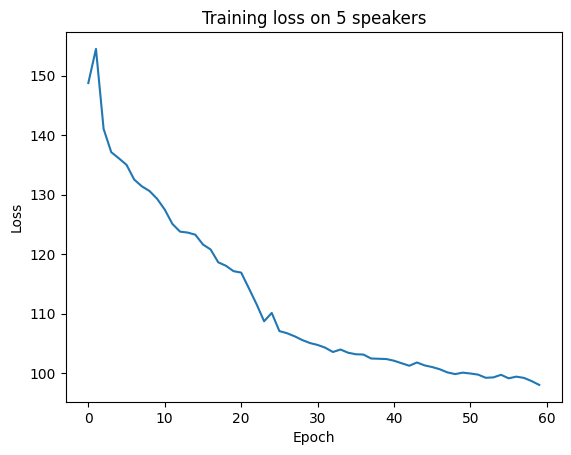

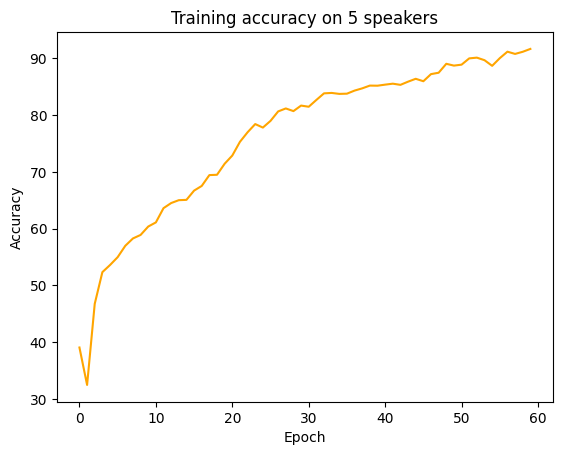

In [73]:
# Loss graph
plt.figure(1)
fig, axs = plt.subplots()
plt.plot(loss_plt)
axs.set_title('Training loss on 5 speakers')
axs.set_ylabel('Loss')
axs.set_xlabel('Epoch')
plt.savefig('Loss: '+ title)
# Accuracy graph
plt.figure(2)
fig, axs = plt.subplots()
plt.plot(acc_plt, color='orange')
axs.set_title('Training accuracy on 5 speakers')
axs.set_ylabel('Accuracy')
axs.set_xlabel('Epoch')
plt.savefig('Accuracy: '+ title)

Test

In [75]:
# Load model
# saved = RNN(input_size, hidden_size, num_layers, num_classes)
model = SpeakerCNN(num_classes)
model.load_state_dict(torch.load('model.ckpt'))
model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        labels = labels.to(device)

        for j in range(images.shape[1]):
            single_image = images[:,j:j + 1,:,:]
        # images = images.view(batch_size, images.shape[1], features_size) # RNN
            outputs = model(single_image)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc = 100 * correct / total

    print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_loader), acc))
# model_acc.append(acc)
print(model_acc)

Test Accuracy of the model on the 98 test images: 86.10271903323263 %
[72.2809667673716, 66.16314199395771, 86.10271903323263]


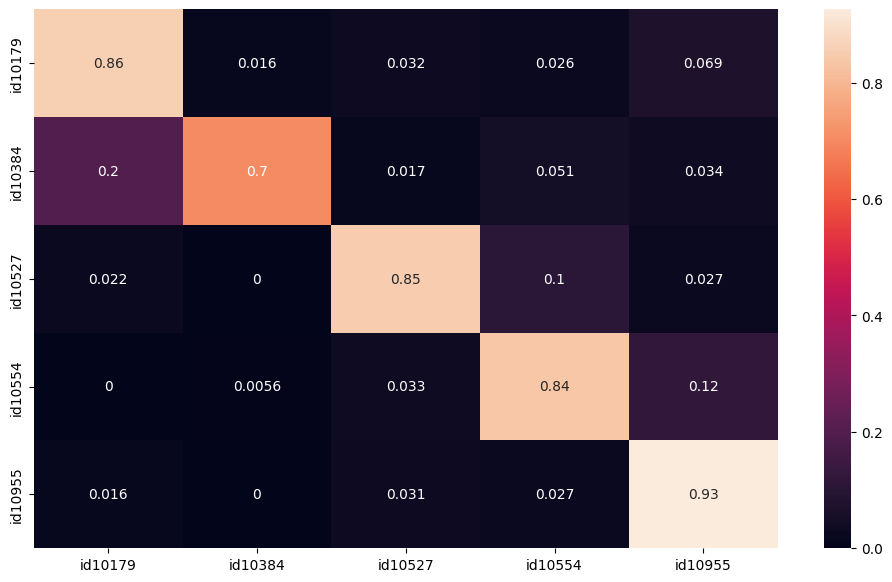

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model = SpeakerCNN(num_classes)
model.load_state_dict(torch.load('model.ckpt'))
model.to(device)
model.eval()
# iterate over test data
for images, labels in test_loader:
    labels = labels.to(device)

    for j in range(images.shape[1]):
        single_image = images[:,j:j + 1,:,:]
        output = model(single_image) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in dataset.labels],
                     columns = [i for i in dataset.labels])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix.png')

# v1.0

Train on: ['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Nelson_Mandela']

Val accuracy: 99.7%

Test on: ['Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela']

Val accuracy: 44.28%

Test on: ['Benjamin_Netanyau', 'Julia_Gillard', 'Nelson_Mandela']

Val accuracy: 77.69%

Test on: ['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Julia_Gillard']

Val accuracy: 81.79%

Test on: ['Jens_Stoltenberg', 'Julia_Gillard', 'Nelson_Mandela']

Val accuracy: 43.61%

# v1.1

Train on: ['Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela']

Val accuracy: 99.33%

Test on: ['Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela']

Val accuracy: 98.66%

Test on: ['Benjamin_Netanyau', 'Magaret_Tarcher', 'Nelson_Mandela']

Val accuracy: 75.88%

Test on: ['Benjamin_Netanyau', 'Julia_Gillard', 'Nelson_Mandela']

Val accuracy: 43.61%

Test on: ['Jens_Stoltenberg', 'Julia_Gillard', 'Nelson_Mandela']

Val accuracy: 45.50%

# v1.2

Train on: Jens_Stoltenberg, Julia_Gillard, Magaret_Tarcher

Val accuracy: 98.33%

Test on: Julia_Gillard, Magaret_Tarcher, Nelson_Mandela

Val accuracy: 0.665%

Test on: Benjamin_Netanyau, Jens_Stoltenberg, Nelson_Mandela

Val accuracy: 24.55%

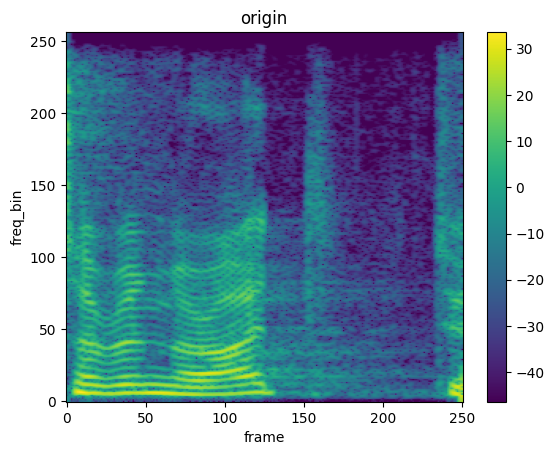

torch.Size([1, 3, 32, 128]) torch.Size([128, 96])


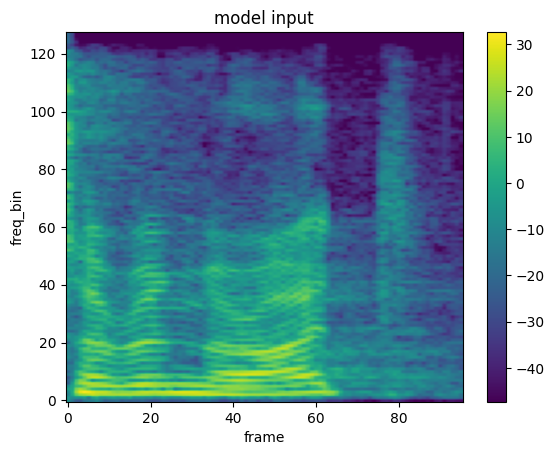

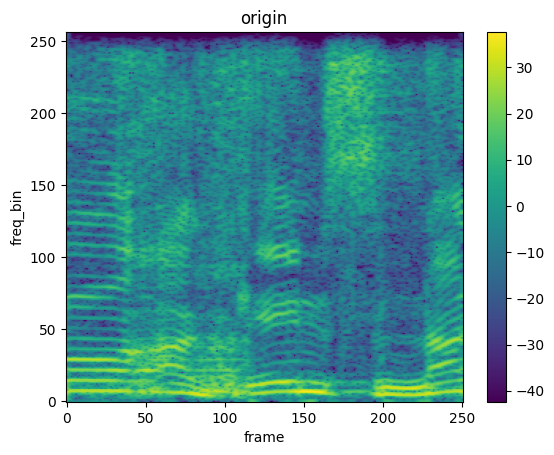

torch.Size([1, 3, 32, 128]) torch.Size([128, 96])


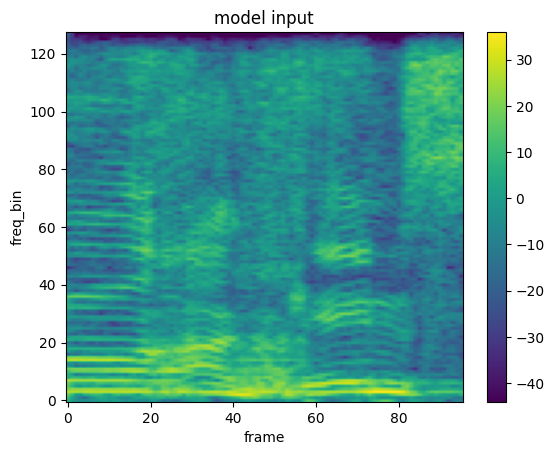

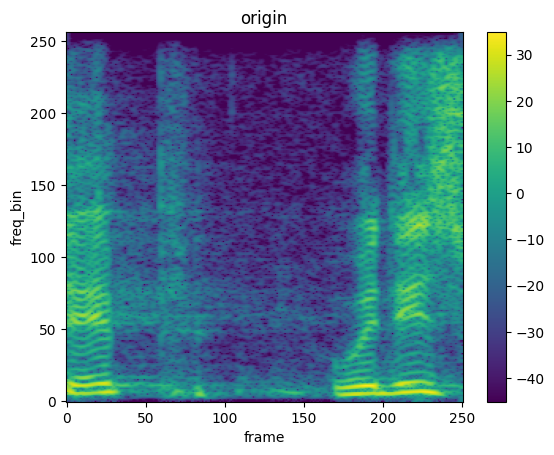

In [ ]:
for i, (images, labels) in enumerate(train_loader):
    if i > 1: break
    # images = images.view(batch_size, images.shape[1], features_size)  # RNN
    images = images.to(device)
    labels = labels.to(device)
    partsCount = images.shape[1]
    plot1 = torch.zeros((partsCount * 32, images.shape[-1]))
    for i in range(partsCount):
        p = i * 32
        plot1[p:p+32,:] = images[0][i]
        # print(plot1[:,i:i+image_width].shape)
    plot1 = torch.transpose(plot1, 0, 1)
    print(images.shape, plot1.shape)
    plot_spectrogram(plot1, title='model input')

Whisper

n_fft = 400
hop_len = 160

In [ ]:
!pip install git+https://github.com/openai/whisper.git
import whisper

model = whisper.load_model("base")
result = model.transcribe(DATA_PATH + "/84/121123/84-121123-0000.flac")
print(result["text"])

# [Speaker Recognition](https://aruno14.medium.com/speaker-recognition-using-tensorflow-1f007c2a7702)

In [ ]:
import csv
import io
import os
import numpy as np
import random
import glob
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPooling2D, Dropout, Flatten, Reshape, AveragePooling2D
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
model_name = "model_speaker_reco"
frame_length = 512 #1024 -> minimal freq ->86Hz for 44100Hz; 512 -> -> minimal freq ->62.5Hz for 16000Hz
step_length = 0.008
image_width = 64 # 0.008*32=256ms
batch_size = 32
epochs = 25

In [ ]:
def audioToTensor(filepath):
    audio_binary = tf.io.read_file(filepath)
    audio, audioSR = tf.audio.decode_wav(audio_binary)
    audioSR = tf.get_static_value(audioSR)
    audio = tf.squeeze(audio, axis=-1)
    frame_step = int(audioSR * step_length)#328
    spectrogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step)
    spect_real = tf.math.real(spectrogram)
    spect_real = tf.abs(spect_real)
    partsCount = len(range(0, len(spectrogram)-image_width, image_width))
    parts = np.zeros((partsCount, image_width, int(frame_length/2+1)))  # 257
    for i, p in enumerate(range(0, len(spectrogram)-image_width, image_width)):
        parts[i] = spect_real[p:p+image_width]
    return parts, audioSR

Tensorflow takes a matrix of data and label as input

PyTorch takes individual data point as input

In [ ]:
X_data = []
Y_data = []
weights = {}
DATA_PATH = ROOT_DIR + "/test_data/leaderspeech"
# print(DATA_PATH)
for i, userFolder in enumerate(glob.glob(DATA_PATH+"/*")):#speakers SRD
    print(i, userFolder)
    for j, audiofile in enumerate(glob.glob(userFolder+"/*.wav")):  # each audio file
        #print("Analyse audiofile:", audiofile)
        parts, SR = audioToTensor(audiofile)    # convert to spec, return list of equal-sized parts (64, 257)
        for part in parts:
            X_data.append(part)
            Y_data.append(i)
            if i not in weights:
                weights[i]=0
            weights[i]+=1
Y_data=tf.keras.utils.to_categorical(Y_data)
print("len(X_data):", len(X_data))
print("weights:", weights)
print("nb cat:", len(weights))
temp = list(zip(X_data, Y_data))
random.shuffle(temp)
X_data, Y_data = zip(*temp)
X_data = np.asarray(X_data)
Y_data = np.asarray(Y_data)
print(X_data.shape)
print(Y_data.shape)
if os.path.exists(model_name):
    print("Load: " + model_name)
    model = load_model(model_name)
else:
    main_input = Input(shape=(image_width, int(frame_length/2+1)), name='main_input')
    x = main_input
    x = Reshape((image_width, int(frame_length/2+1), 1))(x)
    x = preprocessing.Resizing(image_width//2, int(frame_length/2+1)//2)(x)
    x = Conv2D(8, 3, activation='relu', padding="same")(x)
    x = Conv2D(16, 3, activation='relu', padding="same")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(16, 3, activation='relu', padding="same")(x)
    x = Conv2D(32, 3, activation='relu', padding="same")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(32, 3, activation='relu', padding="same")(x)
    x = Conv2D(64, 3, activation='relu', padding="same")(x)
    x = AveragePooling2D(pool_size=3, strides=3)(x)
    x = Dropout(0.1)(x)
    x = Flatten(name="flatten")(x)
    x = Dense(16, name="identification")(x)
    x = Dense(len(weights), activation='sigmoid')(x)
    model = Model(inputs=main_input, outputs=x)
    tf.keras.utils.plot_model(model, to_file='model_id.png', show_shapes=True)
    model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_data[0:int(0.8*len(X_data))], Y_data[0:int(0.8*len(X_data))], epochs=epochs, batch_size=batch_size, class_weight=weights, validation_data=(X_data[int(0.8*len(X_data)):], Y_data[int(0.8*len(X_data)):]))

0 /content/drive/MyDrive/College/Research/Linh_2023_Research/test_data/leaderspeech/Jens_Stoltenberg
1 /content/drive/MyDrive/College/Research/Linh_2023_Research/test_data/leaderspeech/Benjamin_Netanyau
2 /content/drive/MyDrive/College/Research/Linh_2023_Research/test_data/leaderspeech/Magaret_Tarcher
3 /content/drive/MyDrive/College/Research/Linh_2023_Research/test_data/leaderspeech/Nelson_Mandela
4 /content/drive/MyDrive/College/Research/Linh_2023_Research/test_data/leaderspeech/Julia_Gillard
len(X_data): 7501
weights: {0: 1500, 1: 1500, 2: 1500, 3: 1500, 4: 1501}
nb cat: 5
(7501, 64, 257)
(7501, 5)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 64, 257)]         0         
                                                                 
 reshape (Reshape)           (None, 64, 257, 1)        0         
                                              